In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('crimes')

In [3]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train, n_epoch = 500, num_models = 5, hidden_layers = [50, 50], learning_rate = 0.001, tanh = True, exp_decay = .998)

initial loss:  -0.1488732397556305
final loss:  -5.150755882263184
initial loss:  -0.1798919290304184
final loss:  -5.081658363342285
initial loss:  -0.11532313376665115
final loss:  -5.130887508392334
initial loss:  -0.1103500947356224
final loss:  -5.065014362335205
initial loss:  -0.17085495591163635
final loss:  -5.066880226135254


In [8]:
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train, n_epoch = 200, n_features = 30, learning_rate = 0.001, tanh = True)

final loss:  -4.716076850891113


Deep ensemble test MAPE:  0.6427044
Deep ensemble test RMSE:  0.13208164
Deep ensemble test NLLK:  -1.8779993
Deep ensemble test CRPS:  tensor(0.0650)


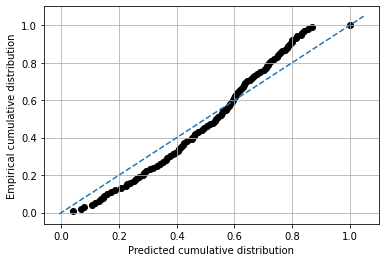

Deep ensemble test calibration error when step size is 0.001:  4.9765694057576875
Deep ensemble test calibration error when step size is 0.01:  0.49559510633658255
Deep ensemble test calibration error when step size is 0.1:  0.041644483211204335


In [5]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Deep ensemble test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

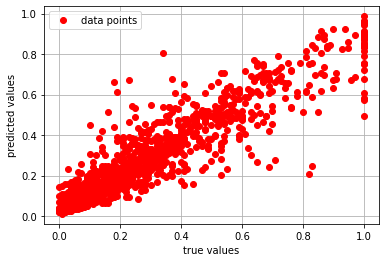

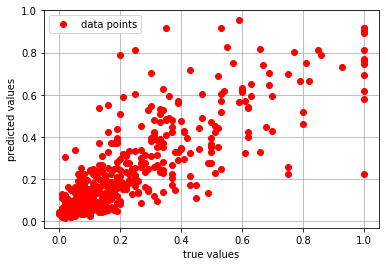

In [6]:
plt.plot(y_train.detach().numpy(), deep_ensemble_model(x_train)[0].detach().numpy().squeeze(1), 'or', label='data points')
plt.grid()
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.legend()
plt.show()

plt.plot(y_test.detach().numpy(), mean_pred.squeeze(1), 'or', label='data points')
plt.grid()
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.legend()
plt.show()

Concrete dropout test MAPE:  0.7224546
Concrete dropout test RMSE:  0.14257436
Concrete dropout test NLLK:  1.5979834
Concrete dropout test CRPS:  tensor(0.0713)


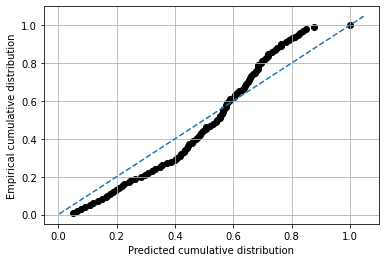

Concrete dropout test calibration error when step size is 0.001:  6.798426537447183
Concrete dropout test calibration error when step size is 0.01:  0.6754181049911749
Concrete dropout test calibration error when step size is 0.1:  0.06243864405942838


In [9]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy())
sd_pred = np.sqrt(var_pred)

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Concrete dropout test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

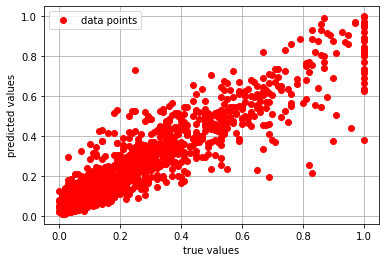

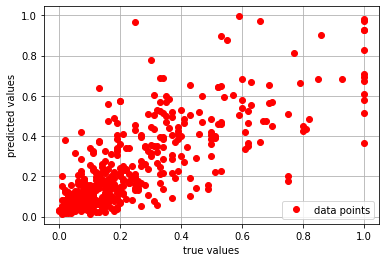

In [10]:
plt.plot(y_train.detach().numpy(), concrete_dropout_model(x_train)[0].detach().numpy().squeeze(1), 'or', label='data points')
plt.grid()
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.legend()
plt.show()

plt.plot(y_test.detach().numpy(), mean_pred.squeeze(1), 'or', label='data points')
plt.grid()
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.legend()
plt.show()